#Problem:


##You are asked to build a real-time computer vision system and ML pipeline to detect bottle caps from a dataset. You need to detect 3 colors, light blue, dark blue and others (for other colors). The dataset contains image and bounding box annotation in YOLO format. You need to adjust the label by yourself according to the color of the object.

##Download dataset

In [1]:
!pip install gdown

import gdown

file_id = "1vbMFTe2E5OHp2h5o_YL-RUoIFKxsrZWT"
url = f"https://drive.google.com/uc?id={file_id}"

output = "bottlecap_dataset.zip"
gdown.download(url, output, quiet=False)

print("Download selesai:", output)


Downloading...
From: https://drive.google.com/uc?id=1vbMFTe2E5OHp2h5o_YL-RUoIFKxsrZWT
To: /content/bottlecap_dataset.zip
100%|██████████| 594k/594k [00:00<00:00, 101MB/s]

Download selesai: bottlecap_dataset.zip


In [2]:
import os, zipfile

zip_path = "bottlecap_dataset.zip"
extract_folder = "bottlecap_dataset"

os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"File berhasil diekstrak ke folder: {extract_folder}")


File berhasil diekstrak ke folder: bottlecap_dataset


##Setup wandb

In [3]:
# pakai versi ini agar aman saat memakai wandb
!pip install ultralytics==8.2.103


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 req

In [1]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aldiantodickyu47 (aldiantodickyu47-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


##Classify each bottlecap into three color categories:
1. light_blue
2. dark_blue
3. others (all other colors or ambiguous cases)

Have labels in YOLO format for model training.

In [3]:
import cv2
import numpy as np
from pathlib import Path
import shutil

ROOT = Path("bottlecap_dataset/sample")
OUT_IMG = Path("yolo_dataset/images")
OUT_LBL = Path("yolo_dataset/labels")

OUT_IMG.mkdir(parents=True, exist_ok=True)
OUT_LBL.mkdir(parents=True, exist_ok=True)

CLASS_MAP = {
    'light_blue': 0,
    'dark_blue': 1,
    'others': 2
}

def classify_color(img, box):
    h, w = img.shape[:2]
    xc, yc, bw, bh = box

    x1 = int((xc - bw/2) * w)
    y1 = int((yc - bh/2) * h)
    x2 = int((xc + bw/2) * w)
    y2 = int((yc + bh/2) * h)

    crop = img[max(0,y1):min(h,y2), max(0,x1):min(w,x2)]
    if crop.size == 0:
        return "others"

    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)

    # Range biru diperluas
    lower_blue = np.array([75, 40, 40])
    upper_blue = np.array([150, 255, 255])
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    ratio = np.count_nonzero(mask) / mask.size

    if ratio > 0.02:  # fix: 2% cukup
        mean_v = np.mean(hsv[:,:,2][mask > 0])
        return "light_blue" if mean_v > 100 else "dark_blue"

    return "others"


# proses semua file
processed = 0

for file in ROOT.iterdir():
    if file.suffix.lower() == ".jpg":
        img = cv2.imread(str(file))
        label_file = ROOT / (file.stem + ".txt")
        if not label_file.exists():
            continue

        new_lines = []

        with open(label_file, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                _, xc, yc, bw, bh = parts
                box = [float(xc), float(yc), float(bw), float(bh)]

                cls = classify_color(img, box)
                cls_id = CLASS_MAP[cls]

                new_lines.append(f"{cls_id} {xc} {yc} {bw} {bh}\n")

        shutil.copy(str(file), OUT_IMG / file.name)

        with open(OUT_LBL / (file.stem + ".txt"), "w") as f:
            f.writelines(new_lines)

        processed += 1
        print(f"Diproses: {processed} → {file.name}")

print("\n Labeling warna ")


Diproses: 1 → raw-250110_dc_s001_b3_4.jpg
Diproses: 2 → raw-250110_dc_s001_b5_3.jpg
Diproses: 3 → raw-250110_dc_s001_b4_3.jpg
Diproses: 4 → raw-250110_dc_s001_b5_2.jpg
Diproses: 5 → raw-250110_dc_s001_b4_1.jpg
Diproses: 6 → raw-250110_dc_s001_b3_2.jpg
Diproses: 7 → raw-250110_dc_s001_b2_1.jpg
Diproses: 8 → raw-250110_dc_s001_b4_2.jpg
Diproses: 9 → raw-250110_dc_s001_b2_3.jpg
Diproses: 10 → raw-250110_dc_s001_b5_5.jpg
Diproses: 11 → raw-250110_dc_s001_b3_3.jpg
Diproses: 12 → raw-250110_dc_s001_b2_15.jpg

 Labeling warna 


##Data Augmentation for Bottlecap Dataset

Increase dataset diversity to improve model generalization.

Simulate real-world variations such as flips, rotations, brightness changes, and small geometric transformations.

In [4]:
import albumentations as A

OUT_IMG_AUG = Path("yolo_dataset_aug/images")
OUT_LBL_AUG = Path("yolo_dataset_aug/labels")

OUT_IMG_AUG.mkdir(parents=True, exist_ok=True)
OUT_LBL_AUG.mkdir(parents=True, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=15, p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for img_file in OUT_IMG.glob('*.jpg'):
    img = cv2.imread(str(img_file))
    lbl_file = OUT_LBL / (img_file.stem + ".txt")

    with open(lbl_file) as f:
        bboxes = []
        class_labels = []
        for line in f:
            cls, xc, yc, w, h = map(float, line.strip().split())
            bboxes.append([xc, yc, w, h])
            class_labels.append(int(cls))

    shutil.copy(img_file, OUT_IMG_AUG / img_file.name)
    shutil.copy(lbl_file, OUT_LBL_AUG / lbl_file.name)

    for i in range(5):
        transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        if len(transformed['bboxes']) == 0:
            continue

        out_img = OUT_IMG_AUG / f"{img_file.stem}_aug{i}.jpg"
        out_lbl = OUT_LBL_AUG / f"{img_file.stem}_aug{i}.txt"

        cv2.imwrite(str(out_img), transformed['image'])

        with open(out_lbl, "w") as f:
            for bbox, cls in zip(transformed['bboxes'], transformed['class_labels']):
                f.write(f"{cls} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

print("Augmentasi selesai")


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Augmentasi selesai


##Train/Validation Split for Bottlecap Dataset

Split the dataset into training and validation sets.

Ensure model is evaluated on unseen data.

Prevent data leakage from augmented images.

In [5]:
from sklearn.model_selection import train_test_split

DATA_DIR = Path('yolo_dataset_split')

for sub in ['images/train', 'images/val', 'labels/train', 'labels/val']:
    (DATA_DIR / sub).mkdir(parents=True, exist_ok=True)

all_imgs = sorted(list(OUT_IMG_AUG.glob('*.jpg')))
img_names = [p.name for p in all_imgs]

# test 0.2
train_names, val_names = train_test_split(img_names, test_size=0.2, random_state=42)

for n in train_names:
    shutil.copy(OUT_IMG_AUG/n, DATA_DIR/'images/train'/n)
    shutil.copy(OUT_LBL_AUG/(Path(n).stem + '.txt'), DATA_DIR/'labels/train'/(Path(n).stem + '.txt'))

for n in val_names:
    shutil.copy(OUT_IMG_AUG/n, DATA_DIR/'images/val'/n)
    shutil.copy(OUT_LBL_AUG/(Path(n).stem + '.txt'), DATA_DIR/'labels/val'/(Path(n).stem + '.txt'))

print("Train:", len(train_names), "Val:", len(val_names))


Train: 57 Val: 15


In [6]:
import yaml

dataset_yaml = {
    'path': '/content/yolo_dataset_split',
    'train': 'images/train',
    'val': 'images/val',
    'names': ['light_blue', 'dark_blue', 'others']
}

with open("dataset_bottlecap.yaml", "w") as f:
    yaml.dump(dataset_yaml, f)

print("dataset_bottlecap.yaml dibuat")



dataset_bottlecap.yaml dibuat


##YOLOv8 Model Training

In [7]:
model = YOLO('yolov8n.pt')

model.train(
    data='dataset_bottlecap.yaml',
    epochs=50,
    imgsz=320,
    batch=4,
    project="bottlecap-detector",
    name="yolov8n-wandb",
    tracker="wandb"
)


100%|██████████| 6.25M/6.25M [00:00<00:00, 411MB/s]

New https://pypi.org/project/ultralytics/8.3.232 available 😃 Update with 'pip install -U ultralytics'


Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset_bottlecap.yaml, epochs=50, time=None, patience=100, batch=4, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=bottlecap-detector, name=yolov8n-wandb, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

100%|██████████| 755k/755k [00:00<00:00, 108MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /content/yolo_dataset_split/labels/train... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<00:00, 2418.64it/s]

train: New cache created: /content/yolo_dataset_split/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/yolo_dataset_split/labels/val... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 3667.20it/s]

val: New cache created: /content/yolo_dataset_split/labels/val.cache


Plotting labels to bottlecap-detector/yolov8n-wandb/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to bottlecap-detector/yolov8n-wandb
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.285G      1.535          4     0.9678          7        320: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         15         98     0.0156      0.757     0.0284      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.247G      1.365      3.183     0.9151         20        320: 100%|██████████| 15/15 [00:01<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.95it/s]

                   all         15         98     0.0207          1      0.126     0.0628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.247G       1.36      2.372     0.9129          7        320: 100%|██████████| 15/15 [00:01<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.95it/s]

                   all         15         98      0.324      0.591      0.446      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      0.25G      1.453      1.984     0.9328         17        320: 100%|██████████| 15/15 [00:01<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.11it/s]

                   all         15         98      0.439      0.673      0.545      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.247G      1.349      1.917     0.9261          4        320: 100%|██████████| 15/15 [00:01<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.03it/s]

                   all         15         98      0.429      0.592      0.497       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      0.25G      1.402      1.818     0.9035          5        320: 100%|██████████| 15/15 [00:01<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.00it/s]

                   all         15         98       0.46      0.505      0.428      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      0.25G      1.434      1.824     0.9212         17        320: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.83it/s]

                   all         15         98      0.765       0.43        0.5      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.247G        1.4      1.662     0.8977         23        320: 100%|██████████| 15/15 [00:01<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.91it/s]

                   all         15         98      0.828      0.479      0.596      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.247G      1.385      1.511     0.9305          7        320: 100%|██████████| 15/15 [00:01<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.00it/s]

                   all         15         98      0.582      0.595       0.62      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.247G      1.274      1.462     0.8981          3        320: 100%|██████████| 15/15 [00:01<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.31it/s]

                   all         15         98      0.544      0.561      0.614      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      0.25G      1.329      1.593     0.9274         10        320: 100%|██████████| 15/15 [00:01<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.39it/s]

                   all         15         98      0.544      0.561      0.614      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.247G      1.266      1.452     0.8824          6        320: 100%|██████████| 15/15 [00:01<00:00,  9.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]


                   all         15         98      0.411      0.779      0.618      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.247G      1.251      1.393     0.9092         21        320: 100%|██████████| 15/15 [00:01<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.21it/s]

                   all         15         98      0.477      0.812      0.651      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.247G      1.214      1.297      0.892          8        320: 100%|██████████| 15/15 [00:01<00:00, 13.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.59it/s]

                   all         15         98      0.579      0.678      0.663      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.247G      1.111        1.3     0.8837          5        320: 100%|██████████| 15/15 [00:01<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.52it/s]

                   all         15         98      0.611      0.808       0.69      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      0.25G      1.205      1.266     0.8926         11        320: 100%|██████████| 15/15 [00:01<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.88it/s]

                   all         15         98      0.649      0.813      0.693      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.247G      1.085      1.232     0.8785         13        320: 100%|██████████| 15/15 [00:01<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.31it/s]

                   all         15         98      0.624      0.857      0.701      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.247G      1.075      1.198     0.8728         21        320: 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.33it/s]

                   all         15         98      0.607      0.862      0.726      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.247G     0.9953      1.288     0.8576          4        320: 100%|██████████| 15/15 [00:01<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.07it/s]

                   all         15         98      0.614      0.859      0.718       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      0.25G       1.04      1.188     0.8597          7        320: 100%|██████████| 15/15 [00:01<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.34it/s]

                   all         15         98      0.603      0.877      0.729      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      0.25G       1.09      1.142     0.8729         10        320: 100%|██████████| 15/15 [00:01<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.50it/s]

                   all         15         98      0.611      0.901      0.763       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.247G      1.151      1.201     0.8864         24        320: 100%|██████████| 15/15 [00:01<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.64it/s]

                   all         15         98      0.622      0.907      0.767        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.247G      1.071      1.128     0.8856          7        320: 100%|██████████| 15/15 [00:01<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         15         98      0.639      0.903      0.754      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      0.25G      1.027      1.116     0.8609         19        320: 100%|██████████| 15/15 [00:01<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.17it/s]

                   all         15         98      0.654      0.868      0.745      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      0.25G      1.047       1.19     0.8853          6        320: 100%|██████████| 15/15 [00:01<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.28it/s]

                   all         15         98      0.675      0.852      0.757      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.247G     0.9934      1.101      0.861         22        320: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.08it/s]

                   all         15         98      0.695      0.955      0.788      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.247G     0.9656      1.056     0.8666          5        320: 100%|██████████| 15/15 [00:01<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.17it/s]

                   all         15         98      0.695      0.955      0.788      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.247G      1.068      1.071     0.8733         17        320: 100%|██████████| 15/15 [00:01<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.48it/s]

                   all         15         98       0.66      0.951      0.789      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.247G      1.049      1.062     0.8586          5        320: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.30it/s]

                   all         15         98      0.613      0.961      0.799      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.247G     0.9597      1.021     0.8589          5        320: 100%|██████████| 15/15 [00:01<00:00, 13.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.62it/s]

                   all         15         98       0.65      0.949      0.805      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.247G       1.04      1.028     0.8798         25        320: 100%|██████████| 15/15 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.68it/s]

                   all         15         98      0.658      0.915      0.799       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      0.25G     0.9693      1.174     0.8659          1        320: 100%|██████████| 15/15 [00:01<00:00, 13.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.07it/s]

                   all         15         98      0.659      0.949      0.799      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      0.25G     0.9823       1.01     0.8406         21        320: 100%|██████████| 15/15 [00:01<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.36it/s]

                   all         15         98      0.656      0.967      0.815       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      0.25G     0.9943     0.9853     0.8564         10        320: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


                   all         15         98      0.633      0.961      0.803      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.247G     0.9664     0.9743     0.8628          6        320: 100%|██████████| 15/15 [00:01<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.81it/s]

                   all         15         98       0.65      0.943      0.819      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      0.25G     0.9278     0.9115     0.8587          5        320: 100%|██████████| 15/15 [00:01<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.08it/s]

                   all         15         98      0.666      0.953      0.832      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      0.25G     0.9219     0.8951     0.8474          8        320: 100%|██████████| 15/15 [00:01<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.51it/s]

                   all         15         98      0.718      0.873      0.857      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      0.25G     0.8777     0.9759     0.8665         17        320: 100%|██████████| 15/15 [00:01<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.90it/s]

                   all         15         98      0.747       0.92       0.87      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      0.25G     0.9692     0.9429     0.8737         10        320: 100%|██████████| 15/15 [00:01<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.81it/s]

                   all         15         98      0.758      0.943      0.889      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      0.25G     0.9044     0.9271     0.8534          5        320: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.45it/s]

                   all         15         98      0.782      0.943      0.924      0.659


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1837: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.243G     0.9398     0.9318     0.8638          5        320: 100%|██████████| 15/15 [00:01<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.69it/s]

                   all         15         98      0.838      0.889      0.915       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.243G     0.9935     0.9221     0.8615          7        320: 100%|██████████| 15/15 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.69it/s]

                   all         15         98      0.831      0.892      0.916      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.243G     0.8921      0.889     0.8458          7        320: 100%|██████████| 15/15 [00:01<00:00, 13.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.27it/s]

                   all         15         98      0.831      0.892      0.916      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.243G     0.9539     0.9182     0.8646          7        320: 100%|██████████| 15/15 [00:01<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.89it/s]

                   all         15         98      0.839      0.861      0.916      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.243G     0.9058     0.8374      0.866          7        320: 100%|██████████| 15/15 [00:01<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]

                   all         15         98      0.808      0.879      0.913      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.243G     0.8794     0.8467     0.8571          8        320: 100%|██████████| 15/15 [00:01<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.27it/s]

                   all         15         98      0.802      0.894      0.916      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.243G     0.9201     0.8412     0.8513          7        320: 100%|██████████| 15/15 [00:01<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.55it/s]

                   all         15         98      0.809      0.914      0.923      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.243G     0.8999     0.8641     0.8529          7        320: 100%|██████████| 15/15 [00:01<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.85it/s]


                   all         15         98        0.8      0.912      0.919      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.243G     0.8647     0.8186     0.8588          5        320: 100%|██████████| 15/15 [00:01<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.07it/s]

                   all         15         98      0.803      0.917      0.926       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.243G     0.8692     0.8012     0.8561          7        320: 100%|██████████| 15/15 [00:01<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.54it/s]

                   all         15         98      0.799      0.917      0.925      0.666



50 epochs completed in 0.034 hours.
Optimizer stripped from bottlecap-detector/yolov8n-wandb/weights/last.pt, 6.2MB
Optimizer stripped from bottlecap-detector/yolov8n-wandb/weights/best.pt, 6.2MB

Validating bottlecap-detector/yolov8n-wandb/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


                   all         15         98      0.803      0.917      0.926      0.672
            light_blue          6         19      0.887      0.895       0.93      0.674
             dark_blue          9         21      0.628      0.857      0.858      0.579
                others         10         58      0.896          1      0.989      0.762
Speed: 0.1ms preprocess, 4.7ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to bottlecap-detector/yolov8n-wandb


lr/pg0,▃▄▅▆▇███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
lr/pg1,▂▃▅▆▇███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
lr/pg2,▂▃▄▅▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
metrics/mAP50(B),▁▂▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
metrics/mAP50-95(B),▁▂▃▄▄▃▅▅▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▆▇▇██████████
metrics/precision(B),▁▁▄▅▅▇█▆▅▅▅▆▆▆▆▆▆▆▆▆▇▇▆▆▆▆▆▆▇▇▇█████████
metrics/recall(B),▅▃▄▃▁▁▃▂▂▅▄▆▆▆▇▇▇▇▇▇██████████▇██▇▇▇▇▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df30842c1d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

##YOLOv8 Model Inference & Visualization

Run the trained YOLOv8 model on validation images.

Visualize predicted bounding boxes and class labels.

Quickly inspect the model’s detection performance.


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b2_1.jpg: 320x288 3 otherss, 38.1ms
Speed: 1.2ms preprocess, 38.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 288)


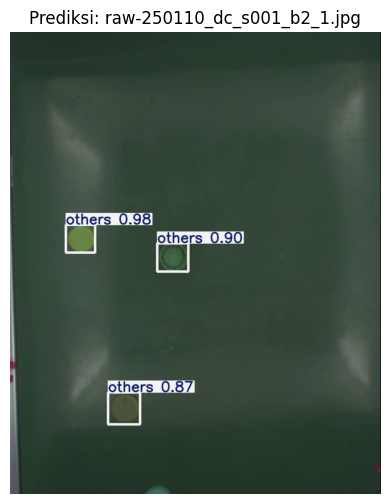


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b2_15.jpg: 320x288 1 light_blue, 8 otherss, 8.4ms
Speed: 2.3ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 288)


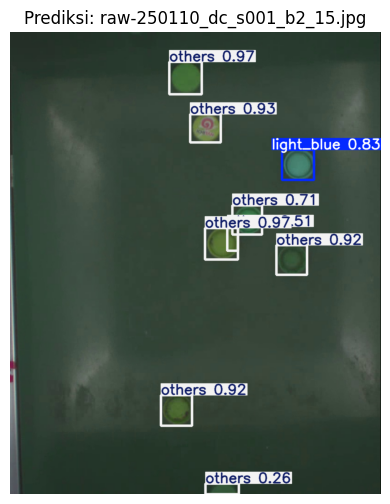


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b2_3.jpg: 320x288 2 light_blues, 1 dark_blue, 5 otherss, 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 288)


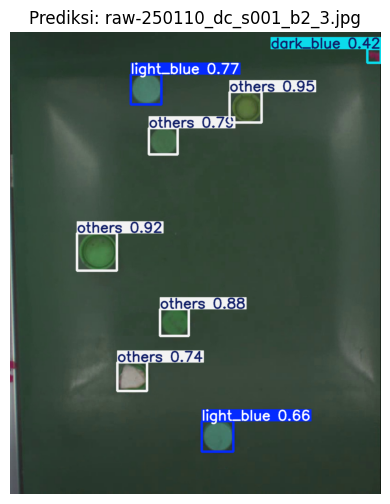


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b3_2.jpg: 320x288 9 otherss, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 288)


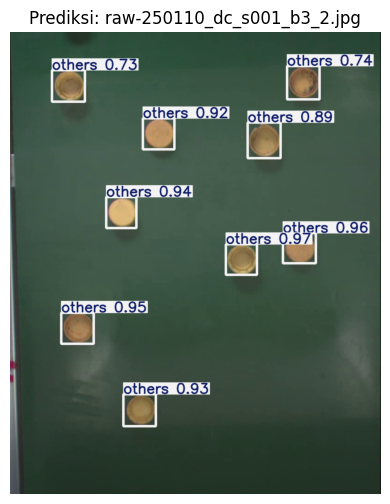


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b3_3.jpg: 320x288 8 otherss, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 288)


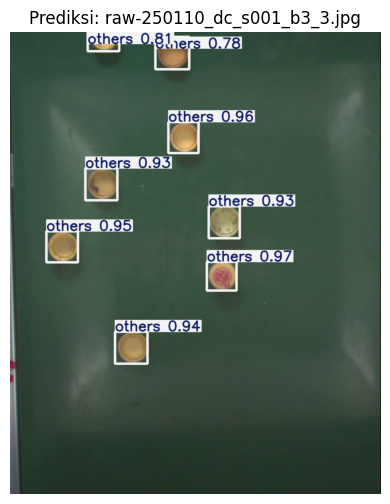


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b3_4.jpg: 320x288 10 otherss, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 288)


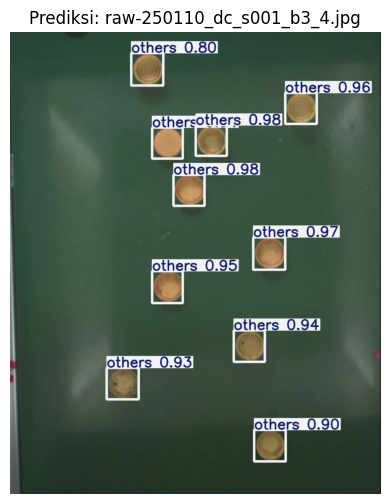


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b4_1.jpg: 320x288 3 light_blues, 3 dark_blues, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 288)


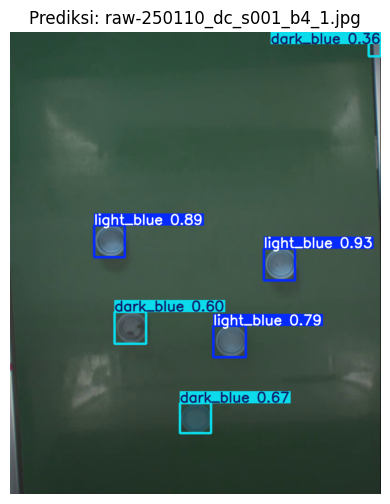


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b4_2.jpg: 320x288 6 light_blues, 1 dark_blue, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 288)


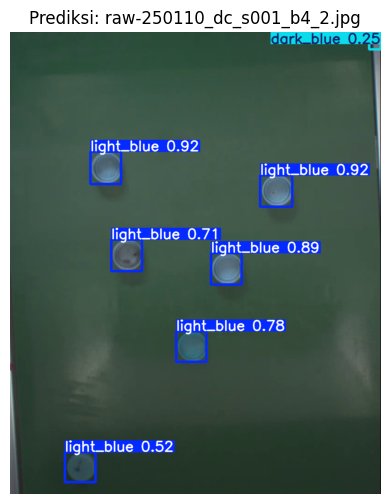


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b4_3.jpg: 320x288 6 light_blues, 2 dark_blues, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 288)


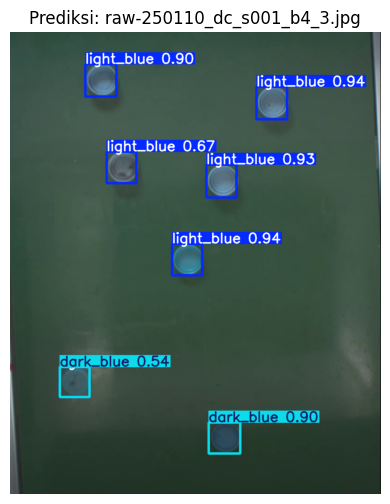


image 1/1 /content/yolo_dataset/images/raw-250110_dc_s001_b5_2.jpg: 320x288 10 dark_blues, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 288)


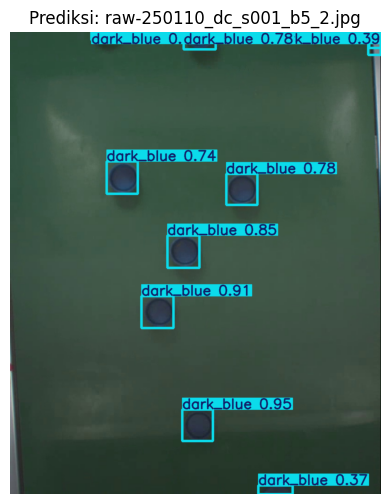

In [8]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

model_path = '/content/bottlecap-detector/yolov8n-wandb/weights/best.pt'
model = YOLO(model_path)

val_dir = Path('/content/yolo_dataset/images')
val_images = sorted(list(val_dir.glob('*.jpg')))

def show_image(img, title=None):
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

for img_file in val_images[:10]:
    res = model.predict(source=str(img_file), conf=0.25, imgsz=320)
    pred_img = res[0].plot()
    show_image(pred_img, title=f"Prediksi: {img_file.name}")


In [29]:
from pathlib import Path
import cv2
import time
from ultralytics import YOLO

# Load model
model = YOLO('/content/bottlecap-detector/yolov8n-wandb/weights/best.pt')

# Ambil semua gambar dari folder
img_folder = Path("/content/yolo_dataset/images")
img_paths = sorted(list(img_folder.glob("*.jpg")))

times = []

for img_path in img_paths:
    print("Memakai gambar:", img_path.name)
    img = cv2.imread(str(img_path))

    # Warm-up untuk setiap gambar (opsional)
    model.predict(img, imgsz=320, verbose=False)

    # Uji 1 kali per gambar, atau bisa diulang beberapa kali
    start = time.time()
    model.predict(img, imgsz=320, verbose=False)
    end = time.time()
    times.append(end - start)

# Rata-rata inference semua gambar
print("Rata-rata per gambar:", sum(times)/len(times), "detik")
print("≈", (sum(times)/len(times))*1000, "ms/frame")


Memakai gambar: raw-250110_dc_s001_b2_1.jpg
Memakai gambar: raw-250110_dc_s001_b2_15.jpg
Memakai gambar: raw-250110_dc_s001_b2_3.jpg
Memakai gambar: raw-250110_dc_s001_b3_2.jpg
Memakai gambar: raw-250110_dc_s001_b3_3.jpg
Memakai gambar: raw-250110_dc_s001_b3_4.jpg
Memakai gambar: raw-250110_dc_s001_b4_1.jpg
Memakai gambar: raw-250110_dc_s001_b4_2.jpg
Memakai gambar: raw-250110_dc_s001_b4_3.jpg
Memakai gambar: raw-250110_dc_s001_b5_2.jpg
Memakai gambar: raw-250110_dc_s001_b5_3.jpg
Memakai gambar: raw-250110_dc_s001_b5_5.jpg
Rata-rata per gambar: 0.007526814937591553 detik
≈ 7.526814937591553 ms/frame


In [ ]:
# dwonload semua file
!zip -r /content/model_development_and_experimentation.zip /content/


#Additional Insights: Model Bias & Dataset Issues

1. Class Imbalance

2. Lighting & Color Variations

3. Small Dataset Limited images

4. Augmentation Limitations: Helps generalization but cannot fully replicate real-world variation

##Recommendations:

1. Collect more diverse images.

2. Balance classes (stratified split or additional data).

3. Consider larger YOLOv8 models if higher accuracy is needed.